Sep 27-29 work on Yang et al. catalog (copy of Sep 25 work)

- re-run MCMC to find the value + error of parameters

- sum up + error bar;

- plot M_h vs N_GC;

-> final results are in '/data/lemn/results/M_h_NGCs_err_b30000(or b100, b1000).fits'

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from astropy.table import Table

In [4]:
import astropy.io.fits as fits

In [5]:
import corner

In [6]:
import emcee

In [7]:
from scipy.optimize import minimize

In [8]:
from IPython.display import display, Math

do MCMC

In [9]:
#load data 
data = fits.getdata('/data/lemn/results/NGC_Magz.fits')

In [10]:
y = data['NGCs']
x = data['Mag z']
yerr = data['err GC']

In [11]:
a = np.argwhere(~np.isnan(x)) #find idx of non nan values in Mag z

In [12]:
x    = x[a]
y    = y[a]
yerr = yerr[a]

In [13]:
x    = x.reshape((len(a)))
y    = y.reshape((len(a)))
yerr = yerr.reshape((len(a)))

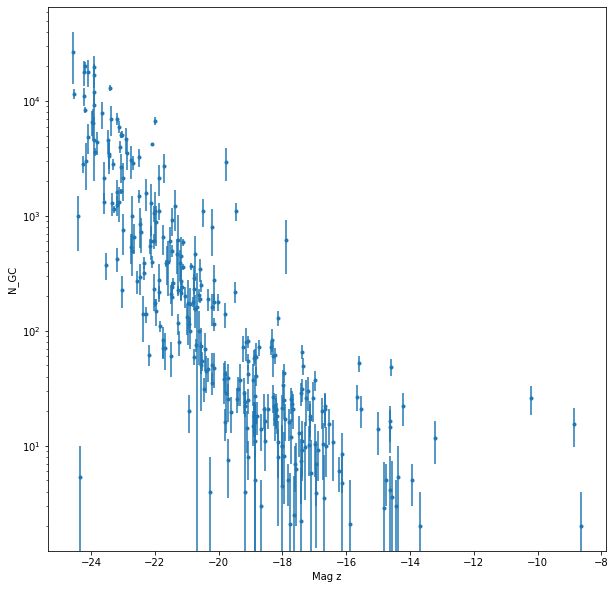

In [14]:
plt.figure(figsize=(10,10))
plt.yscale('log')
plt.errorbar(x, y, yerr=yerr, fmt=".", capsize=0)
plt.xlabel("Mag z")
plt.ylabel("N_GC");

Try with the model as Moster

$y(x) = a\left(\frac{x}{M_1}\right)^{\alpha} + b\left(\frac{x}{M_1}\right)^{\beta}$

In [15]:
def model(theta, x):
    a, alpha, b, beta, M1, log_f = theta
    model = a*(x/M1)**alpha + b*(x/M1)**beta
    return model

In [16]:
def log_likelihood(theta, x, y, yerr):
    a, alpha, b, beta, M1, log_f = theta
    sigma2 = yerr**2 + model(theta,x)**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model(theta,x)) ** 2 / sigma2 + np.log(sigma2))


In [17]:
#initial values (guess)
a_ini     = 5
alpha_ini = 2 
b_ini     = 8
beta_ini  = 2
M1_ini    = -20
f_ini     = 0.2 
ini  = np.array([a_ini, alpha_ini, b_ini, beta_ini, M1_ini, np.log(f_ini)]) 
ndim = len(ini)

In [18]:
np.random.seed(42)
nll     = lambda *args: -log_likelihood(*args)
initial = ini + 1e-3 * np.random.randn(ndim)
soln    = minimize(nll, initial, args=(x, y, yerr))
a_ml, alpha_ml, b_ml, beta_ml, M1_ml, log_f_ml = soln.x

theta_ml = [a_ml, alpha_ml, b_ml, beta_ml, M1_ml, log_f_ml]

print("Maximum likelihood estimates:")
print("a     = {0:.3f}".format(a_ml))
print("alpha = {0:.3f}".format(alpha_ml))
print("b     = {0:.3f}".format(b_ml))
print("beta  = {0:.3f}".format(beta_ml))
print("M1    = {0:.3f}".format(M1_ml))
print("f     = {0:.3f}".format(np.exp(log_f_ml)))

Maximum likelihood estimates:
a     = 15.651
alpha = 0.865
b     = 19.523
beta  = 27.113
M1    = -19.223
f     = 0.799


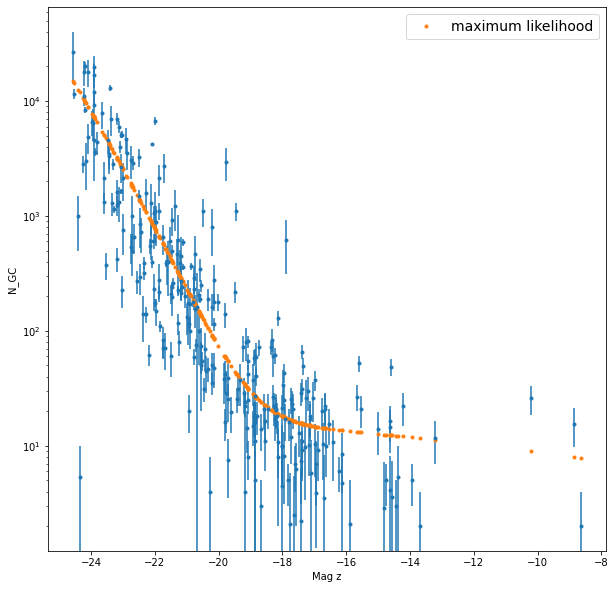

In [19]:
plt.figure(figsize=(10,10))
plt.errorbar(x, y, yerr=yerr, fmt=".", capsize=0)
plt.plot(x, model(theta_ml, x), '.', label = 'maximum likelihood')
plt.legend(fontsize=14)
plt.xlabel("Mag z")
plt.yscale('log')
plt.ylabel("N_GC");

In [68]:
def log_prior(theta):
    a, alpha, b, beta, M1, log_f = theta
    if 0. < a < 30. and -5 < alpha < 5 and 0 < b < 30000 and 0 < beta < 40. and -25 < M1 < -15 and -10.0 < log_f < 10:
        return 0.0
    return -np.inf

In [69]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)


In [70]:
nwalkers = 240 # no. of paramters x 40
pos = soln.x + 1e-4 * np.random.randn(nwalkers, ndim)
niter = 70000  # nwalkers x 1000

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
sampler.run_mcmc(pos, niter, progress=True);

You must install the tqdm library to use progress indicators with emcee


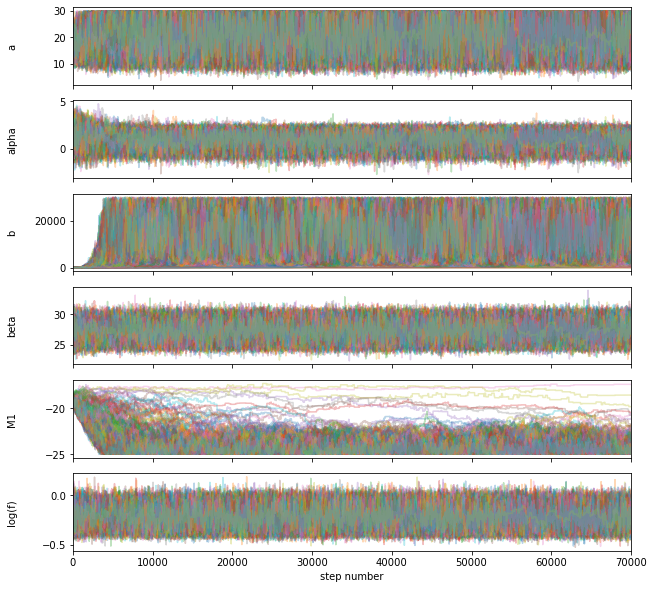

In [71]:
fig, axes = plt.subplots(ndim, figsize=(10, 10), sharex=True)
samples = sampler.get_chain()
labels = ["a", 'alpha', "b", 'beta', 'M1', "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [72]:
tau = sampler.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1400;
tau: [ 409.92808831  336.74509479 2024.1520808   295.78801731 3806.25879258
  276.17635342]

In [73]:
flat_samples = sampler.get_chain(discard=100, thin=500, flat=True) #thin the samples ~ 0.5 of autocorr time
print(flat_samples.shape)

(33360, 6)


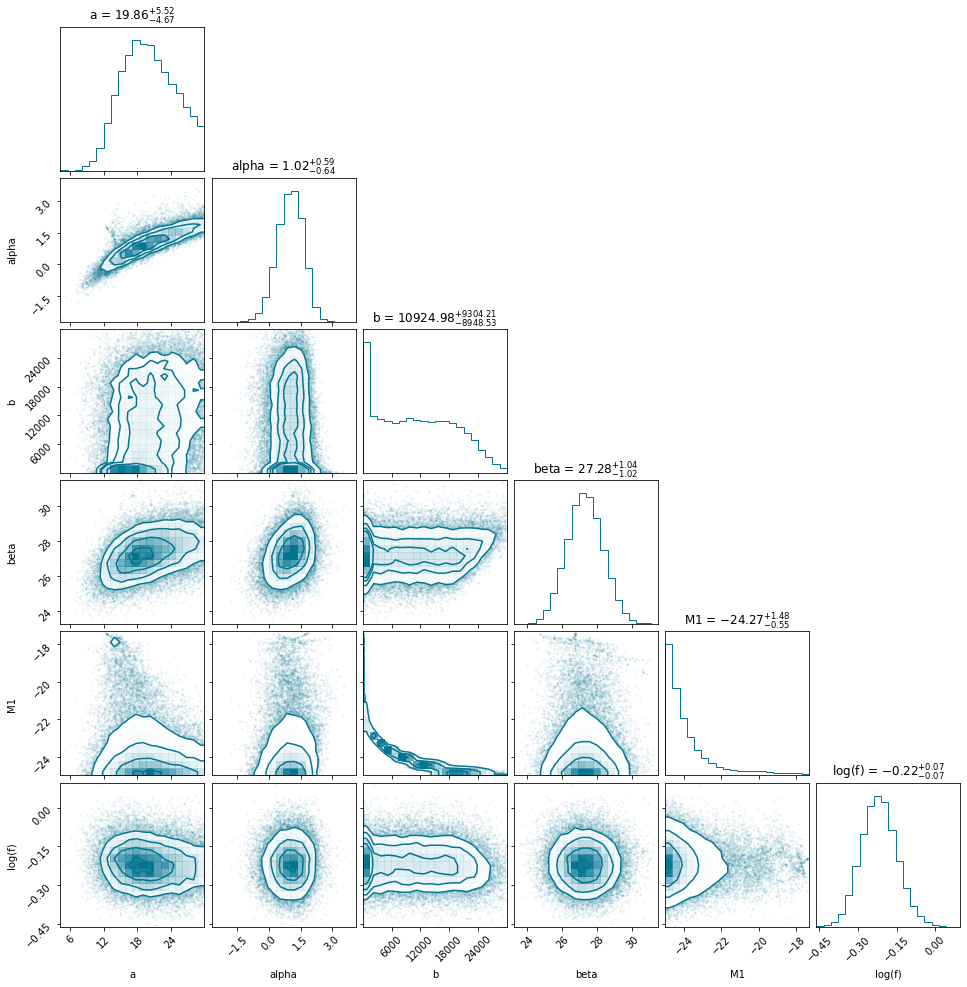

In [74]:
fig = corner.corner(flat_samples, show_titles=True,labels=labels, color='#047591')
#fig.savefig('corner_constrain.pdf')

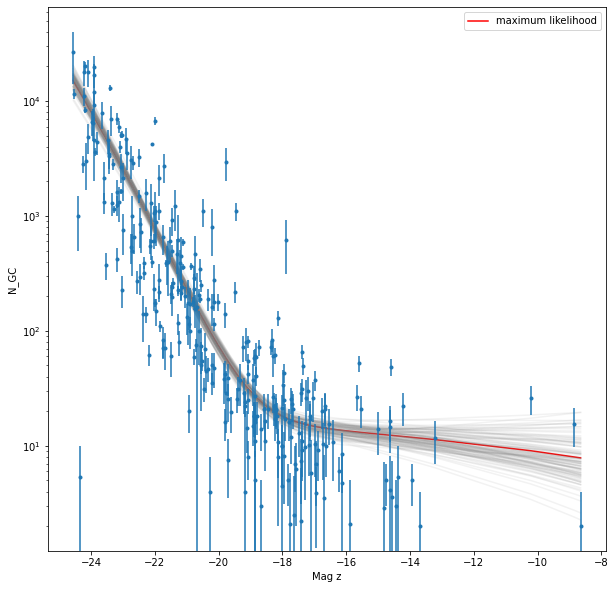

In [75]:
inds = np.random.randint(len(flat_samples), size=100)
plt.figure(figsize=(10,10))
plt.yscale('log')
models = []
x2 = np.sort(x)
plt.plot(x2, model(theta_ml, x2), 'r-', label = 'maximum likelihood')
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x2, model(sample,x2), color='grey', alpha = 0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".", capsize=0)
plt.xlabel("Mag z")
plt.ylabel("N_GC")
plt.legend()
#plt.savefig('parameters_100.pdf')

In [76]:
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

apply model on data in Yang catalog

In [29]:
path='/data/lemn/DESIdata/'

In [30]:
#load Mag z
data = fits.getdata(path+'galaxies/DESIDR9_NGC_galaxy.fits')

In [31]:
Mag_z = data['M_zband']

In [77]:
theta = np.zeros(ndim)
theta_plus = np.zeros(ndim)
theta_minus = np.zeros(ndim)

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    theta[i] = mcmc[1]
    theta_plus[i] = theta[i] + q[1]
    theta_minus[i] = theta[i] - q[0]

In [78]:
N_GC = model(theta, Mag_z)

In [79]:
N_GC_plus= model(theta_plus, Mag_z)

In [80]:
N_GC_minus = model(theta_minus, Mag_z)

In [36]:
print(N_GC, N_GC_plus, N_GC_minus)

[ 40.19404175 980.63699642 141.86590881 ...  33.08558404 279.05406518
 531.95631396] [ 133.94012899 5289.80760693  650.97122718 ...   99.85477546 1380.66903857
 2765.8909563 ] [ 19.14610984 200.95289105  40.1947834  ...  17.59863586  67.45308201
 116.34835923]


calculate total N_GCs and total errors

In [37]:
#load infor of members in group
mem = fits.getdata(path+'members/iDESIDR9_NGC_1.fits')

In [38]:
igroup_ID = mem['groupID']

In [39]:
#load infor of members in group
group = fits.getdata(path+'groups/DESIDR9_NGC_group.fits')

In [40]:
group_ID = group['groupID']

In [41]:
richness = group['richness']

In [42]:
richness = richness.astype(int)

In [43]:
M_group = group['log M_h [M_sun/h]'] #[M_sun/h]

In [44]:
h = 0.7                    #Planck parameters
M_group = 10**(M_group)*h  # [M_sun], unit in catalog is log10 Msun

In [45]:
sort_id = np.argsort(igroup_ID)

 algorithm

In [81]:
import time
t0 = time.time()

In [82]:
test3 = np.zeros(len(M_group))
plus3 = np.zeros(len(M_group))
minus3 = np.zeros(len(M_group))

In [83]:
#the remaining terms
start = 0
for i in range(0,len(M_group)):
    stop = start + richness[i]
    for j in range(start,stop):
        test3[i] += N_GC[sort_id[j]]
        plus3[i]      += N_GC_plus[sort_id[j]]
        minus3[i]     += N_GC_minus[sort_id[j]]
    start = stop

In [84]:
t1 = time.time()
print('running time', t1-t0)

running time 118.54437637329102


In [95]:
data = fits.getdata('/data/lemn/results/M_h_NGCs_plus_minus.fits')
#M_group = data3['M_h M_sun']
N_GC_1000 = data['NGCs']
plus_1000 = data['plus']
minus_1000 = data['minus']

In [94]:
data3 = fits.getdata('/data/lemn/results/M_h_NGCs_plus_minus_b100.fits')
#M_group = data3['M_h M_sun']
N_GC_100 = data3['NGCs']
plus_100 = data3['plus']
minus_100 = data3['minus']

In [96]:
#calculate asymetric errors
lower_err_100 = N_GC_100 - minus_100
upper_err_100 = plus_100 - N_GC_100

In [98]:
#calculate asymetric errors
lower_err_1000 = N_GC_1000 - minus_1000
upper_err_1000 = plus_1000 - N_GC_1000

In [99]:
#calculate asymetric errors
lower_err3 = test3 - minus3
upper_err3 = plus3 - test3

In [120]:
asymm_error_100 = [lower_err_100, upper_err_100]
asymm_error_1000 = [lower_err_1000, upper_err_1000]
asymm_error_3 = [lower_err3, upper_err3]

In [102]:
i_plot = np.random.rand(50,10)
i_plot *= len(M_group)
i_plot = i_plot.reshape(500)
i_plot = i_plot.astype(int)

In [106]:
asymmetric_error_100 = [lower_err_100[i_plot], upper_err_100[i_plot]]
asymmetric_error_1000 = [lower_err_1000[i_plot], upper_err_1000[i_plot]]
asymmetric_error3 = [lower_err3[i_plot], upper_err3[i_plot]]

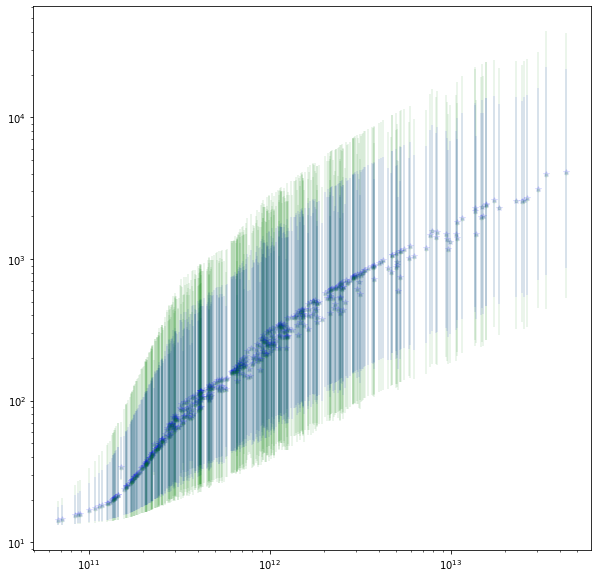

In [112]:
#compare b<100 and b<1000
plt.figure(figsize=(10,10))
plt.xscale('log')
plt.yscale('log')
plt.errorbar(M_group[i_plot], N_GC_100[i_plot], yerr = asymmetric_error_100, fmt= 'b*',alpha=0.1)
#plt.errorbar(M_group[i_plot], N_GC_1000[i_plot], yerr = asymmetric_error_1000, fmt= 'y>',alpha=0.1)
plt.errorbar(M_group[i_plot], test3[i_plot], yerr = asymmetric_error3, fmt= 'g.',alpha=0.1)
#plt.errorbar(M_group, N_GC, yerr = asymm_error, fmt= '.',alpha=0.1)
plt.show()
#=> for b in larger prior range, the 1-sigma error bars is larger, but not much between b<100 and b<30000

plot results together with other data

In [13]:
#load theory results
M_halo_theo                 = np.loadtxt("/data/lemn/theory_results/theory_Creaseymodel.txt" ,usecols=(0))
N_GC_Mill_Creaseytheo       = np.loadtxt("/data/lemn/theory_results/theory_Creaseymodel.txt" ,usecols=(1))
err_N_GC_Mill_Creaseytheo   = np.loadtxt("/data/lemn/theory_results/theory_Creaseymodel.txt" ,usecols=(2))
N_GC_Planck_Creaseytheo     = np.loadtxt("/data/lemn/theory_results/theory_Creaseymodel.txt" ,usecols=(3))
err_N_GC_Planck_Creaseytheo = np.loadtxt("/data/lemn/theory_results/theory_Creaseymodel.txt" ,usecols=(4))
N_GC_COCO_Creaseytheo       = np.loadtxt("/data/lemn/theory_results/theory_Creaseymodel.txt" ,usecols=(5))
err_N_GC_COCO_Creaseytheo   = np.loadtxt("/data/lemn/theory_results/theory_Creaseymodel.txt" ,usecols=(6))
M_halo_theo2                = np.loadtxt("/data/lemn/theory_results/theory_ourmodel.txt"     ,usecols=(0))
N_GC_Mill_ourtheo           = np.loadtxt("/data/lemn/theory_results/theory_ourmodel.txt"     ,usecols=(1))
err_N_GC_Mill_ourtheo       = np.loadtxt("/data/lemn/theory_results/theory_ourmodel.txt"     ,usecols=(2))
N_GC_Planck_ourtheo         = np.loadtxt("/data/lemn/theory_results/theory_ourmodel.txt"     ,usecols=(3))
err_N_GC_Planck_ourtheo     = np.loadtxt("/data/lemn/theory_results/theory_ourmodel.txt"     ,usecols=(4))
N_GC_COCO_ourtheo           = np.loadtxt("/data/lemn/theory_results/theory_ourmodel.txt"     ,usecols=(5))
err_N_GC_COCO_ourtheo       = np.loadtxt("/data/lemn/theory_results/theory_ourmodel.txt"     ,usecols=(6))

In [14]:
# load EMOSAICS Fig.1 data
mass_E   = np.loadtxt('/data/lemn/datalit/EMOSAICS_data.txt', usecols =(0))
triangle = np.loadtxt('/data/lemn/datalit/EMOSAICS_data.txt', usecols =(1))
square   = np.loadtxt('/data/lemn/datalit/EMOSAICS_data.txt', usecols =(2))
star     = np.loadtxt('/data/lemn/datalit/EMOSAICS_data.txt', usecols =(3))

In [15]:
#load Forbes 18 data
M_halo_F = np.loadtxt('/data/lemn/datalit/Forbes18_data.txt',usecols=(2))
N_GC_F   = np.loadtxt('/data/lemn/datalit/Forbes18_data.txt',usecols=(3))
M_halo_F = 10**M_halo_F

In [16]:
#load blue GCs from Creasey data
M_Creasey = np.loadtxt('/data/lemn/datalit/Creasey_Data.txt',usecols=(0))
N_Creasey = np.loadtxt('/data/lemn/datalit/Creasey_Data.txt',usecols=(1))

In [17]:
Atlas_H = fits.getdata('/data/lemn/results/M_h_NGCs_Harris-Atlas.fits')

In [18]:
check     = Atlas_H['check T F central']
sum_NGC   = Atlas_H['NGCs']
M_h_array = Atlas_H['M_h M_sun']

In [19]:
dd = fits.getdata('/data/lemn/results/M_h_NGCs_test2.fits')
N_2 = dd['NGCs']

In [ ]:

plt.figure(figsize=(12,12))
plt.xscale("log")
plt.yscale('log')

plt.errorbar(M_group, test3, yerr = asymm_error_3, fmt= 'y.',alpha = 0.01,label='Yang catalog' )
#plt.loglog(M_group, N_GC,'.', alpha = 0.1, label='Yang catalog' )

plt.errorbar(M_halo_theo, N_GC_Mill_Creaseytheo,  yerr=err_N_GC_Mill_Creaseytheo,  color = '#a5c215', fmt='--',label='Creasey model, P_Mill')
plt.errorbar(M_halo_theo, N_GC_Planck_Creaseytheo,yerr=err_N_GC_Planck_Creaseytheo,color = '#186878', fmt='--',label='Creasey model, P_Planck')
plt.errorbar(M_halo_theo, N_GC_COCO_Creaseytheo,  yerr=err_N_GC_COCO_Creaseytheo,  color = '#c23215', fmt='--',label='Creasey model, P_COCO')
plt.errorbar(M_halo_theo2,N_GC_Mill_ourtheo,      yerr=err_N_GC_Mill_ourtheo,      color = '#a5c215',label='our model, P_Mill')
plt.errorbar(M_halo_theo2,N_GC_Planck_ourtheo,    yerr=err_N_GC_Planck_ourtheo,    color = '#186878',label='our model, P_Planck')
plt.errorbar(M_halo_theo2,N_GC_COCO_ourtheo,      yerr=err_N_GC_COCO_ourtheo,      color = '#c23215',label='our model, P_COCO')

plt.plot(mass_E, triangle, 'v-', label = 'EMOSAICS $M \geq 10^5 M_\odot$')
plt.plot(mass_E, square,   's-', label = 'EMOSAICS $M \geq 10^5 M_\odot$ and $[Fe/H]$')
plt.plot(mass_E, star, '*-',     label = 'EMOSAICS $M \geq 10^5 M_\odot$, $[Fe/H]$ and $R > R_{1/2 M_\star}$')

plt.plot(M_Creasey, N_Creasey, 'g+', label ='Creasey data')
plt.plot(M_halo_F, N_GC_F, 'm+',     label ='Forbes18 data')

for i in range(0,len(check)):
    if check[i] == 1:
        plt.plot(M_h_array[i],sum_NGC[i], 'bo')#, label = '#GCs in halos, true cen, Harris+Rvir data')

plt.xlabel('$M_h [M_\odot]$')
plt.ylabel('$N_{GC}$')
plt.legend()
#plt.savefig('tot_GC_1sigma.pdf')
plt.show()

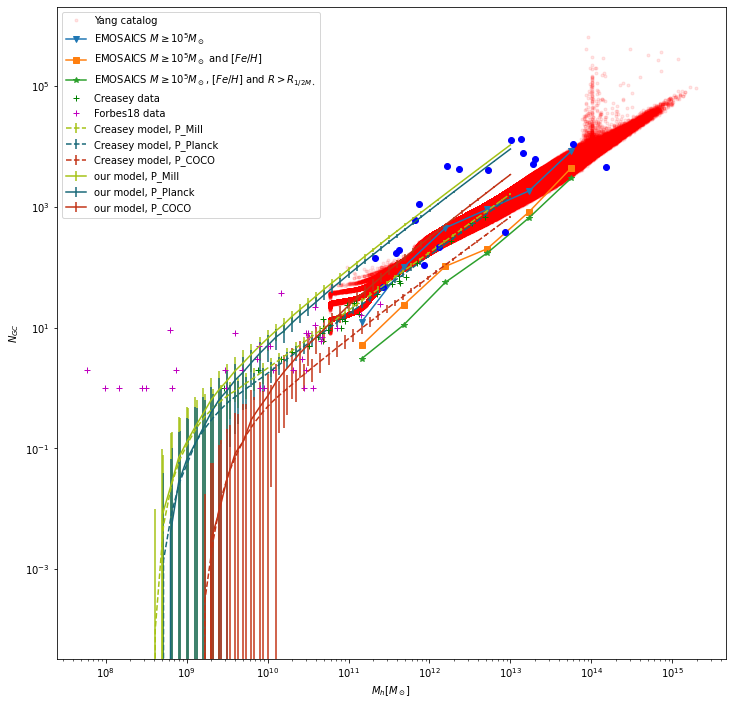

In [22]:

plt.figure(figsize=(12,12))
plt.xscale("log")
plt.yscale('log')

plt.loglog(M_group, N_GC,'r.', alpha = 0.1, label='Yang catalog' )

plt.errorbar(M_halo_theo, N_GC_Mill_Creaseytheo,  yerr=err_N_GC_Mill_Creaseytheo,  color = '#a5c215', fmt='--',label='Creasey model, P_Mill')
plt.errorbar(M_halo_theo, N_GC_Planck_Creaseytheo,yerr=err_N_GC_Planck_Creaseytheo,color = '#186878', fmt='--',label='Creasey model, P_Planck')
plt.errorbar(M_halo_theo, N_GC_COCO_Creaseytheo,  yerr=err_N_GC_COCO_Creaseytheo,  color = '#c23215', fmt='--',label='Creasey model, P_COCO')
plt.errorbar(M_halo_theo2,N_GC_Mill_ourtheo,      yerr=err_N_GC_Mill_ourtheo,      color = '#a5c215',label='our model, P_Mill')
plt.errorbar(M_halo_theo2,N_GC_Planck_ourtheo,    yerr=err_N_GC_Planck_ourtheo,    color = '#186878',label='our model, P_Planck')
plt.errorbar(M_halo_theo2,N_GC_COCO_ourtheo,      yerr=err_N_GC_COCO_ourtheo,      color = '#c23215',label='our model, P_COCO')

plt.plot(mass_E, triangle, 'v-', label = 'EMOSAICS $M \geq 10^5 M_\odot$')
plt.plot(mass_E, square,   's-', label = 'EMOSAICS $M \geq 10^5 M_\odot$ and $[Fe/H]$')
plt.plot(mass_E, star, '*-',     label = 'EMOSAICS $M \geq 10^5 M_\odot$, $[Fe/H]$ and $R > R_{1/2 M_\star}$')

plt.plot(M_Creasey, N_Creasey, 'g+', label ='Creasey data')
plt.plot(M_halo_F, N_GC_F, 'm+',     label ='Forbes18 data')

for i in range(0,len(check)):
    if check[i] == 1:
        plt.plot(M_h_array[i],sum_NGC[i], 'bo')#, label = '#GCs in halos, true cen, Harris+Rvir data')

plt.xlabel('$M_h [M_\odot]$')
plt.ylabel('$N_{GC}$')
plt.legend()
#plt.savefig('tot_GC_Yang.pdf')
plt.show()